In [1]:
#Mixed Naive bayes library installation
pip install git+https://github.com/remykarem/mixed-naive-bayes#egg=mixed_naive_bayes

  Cloning https://github.com/remykarem/mixed-naive-bayes to /tmp/pip-install-ut2znaob/mixed-naive-bayes
  Running command git clone -q https://github.com/remykarem/mixed-naive-bayes /tmp/pip-install-ut2znaob/mixed-naive-bayes
  Created wheel for mixed-naive-bayes: filename=mixed_naive_bayes-0.0.1-cp36-none-any.whl size=10099 sha256=a1b23338f8a6eb3d5ea84a0857544ce92a3dca7b56bf5b8b175099b62bd9399f
  Stored in directory: /tmp/pip-ephem-wheel-cache-2u7gvmwa/wheels/75/c7/39/3f5ba0eed16e20d82f06cd8a97ac747f32e14e3679bcec600b
Successfully built mixed-naive-bayes


In [0]:
"""Please run this python notebook on google colab paltform to avoid errors files 
directories or modifiy the dirictories in the next fields according to the plat-
form you are using now"""
# Related Libraries Importing
import pandas as pd
import numpy as np
import glob as gl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from mixed_naive_bayes import MixedNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import  train_test_split
import warnings
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree.export import export_text
warnings.filterwarnings("ignore")

In [3]:
#Phase (1): Data Acquirement
#Objective: Partial datasets grouping and operating condition attachment
"""Note: Please make sure that you uploaded the 18 sub-datasets
named with experiment_#.csv (#=1-18) as well as the train from
the data folder file before running this cell to avoid error"""

#Partial datasets grouping
Data_File_Paths= [i for i in gl.glob('/content/*.csv')]
Data_File_Paths.sort()
y=[pd.read_csv(x) for x in Data_File_Paths]
Combined_Dataset=pd.concat([pd.read_csv(x) for x in Data_File_Paths[:-1]],
                           ignore_index=True)

#Extracting the lengths each sub-dataset 
length=[]
for x in Data_File_Paths[:-1]:
  length.append(len(pd.read_csv(x)))
Operating_Conditions=pd.read_csv('/content/train.csv')

#Extracting the operation conditions and class label Values
Feed_Rate_Val=list(Operating_Conditions['feedrate'])
Clamping_Pressure_Val=list(Operating_Conditions['clamp_pressure'])
Tool_Condition_Val=list(Operating_Conditions['tool_condition'])

#Equating the opration condition and class label values to the sub-datasets length

for i in range(18):
  Feed_Rate_Val+=Feed_Rate_Val[i:i+1]*length[i]
  Clamping_Pressure_Val+=Clamping_Pressure_Val[i:i+1]*length[i]
  Tool_Condition_Val+=Tool_Condition_Val[i:i+1]*length[i]
del Feed_Rate_Val[0:18]
del Clamping_Pressure_Val[0:18]
del Tool_Condition_Val[0:18]

#Operation conditions and class labeles attachment to the full dataset
Combined_Dataset.insert(loc=46,column='Feed_Rate',value=Feed_Rate_Val)
Combined_Dataset.insert(loc=47,column='Clamp',value=Clamping_Pressure_Val)
Combined_Dataset.insert(loc=50,column='Class',value=Tool_Condition_Val)

Combined_Dataset.head()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualPosition,Y1_ActualVelocity,Y1_ActualAcceleration,Y1_CommandPosition,Y1_CommandVelocity,Y1_CommandAcceleration,Y1_CurrentFeedback,Y1_DCBusVoltage,Y1_OutputCurrent,Y1_OutputVoltage,Y1_OutputPower,Z1_ActualPosition,Z1_ActualVelocity,Z1_ActualAcceleration,Z1_CommandPosition,Z1_CommandVelocity,Z1_CommandAcceleration,Z1_CurrentFeedback,Z1_DCBusVoltage,Z1_OutputCurrent,Z1_OutputVoltage,S1_ActualPosition,S1_ActualVelocity,S1_ActualAcceleration,S1_CommandPosition,S1_CommandVelocity,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,Feed_Rate,Clamp,M1_CURRENT_FEEDRATE,Machining_Process,Class
0,198.0,0.0,0.00,198.0,0.0,0.0,0.18,0.02,329.0,2.77,0.00,158.0,-0.03,-6.25,158.0,0.0,0.0,0.54,0.02,328.0,1.84,0.00,119.0,0.0,0.00,119.0,0.0,0.0,0.0,0.0,0.0,0.0,-361.0,0.0,0.25,-361.0,0.0,0.0,0.52,0.0,329.0,0.0,0.0,12.0,1.0,0.0,6,4.0,50.0,Starting,unworn
1,198.0,-10.8,-350.00,198.0,-13.6,-358.0,-10.90,0.19,328.0,23.30,0.00,158.0,-19.80,-750.00,157.0,-24.6,-647.0,-14.50,0.28,325.0,37.80,0.01,119.0,-20.3,-712.00,118.0,-25.6,-674.0,0.0,0.0,0.0,0.0,-361.0,0.0,0.25,-361.0,0.0,0.0,-0.29,0.0,328.0,0.0,0.0,12.0,1.0,4.0,6,4.0,50.0,Prep,unworn
2,196.0,-17.8,-6.25,196.0,-17.9,0.0,-8.59,0.14,328.0,30.60,0.01,154.0,-32.50,0.00,154.0,-32.3,0.0,-7.79,0.14,327.0,49.40,0.01,115.0,-33.7,37.50,115.0,-33.7,0.0,0.0,0.0,0.0,0.0,-361.0,0.0,-0.44,-361.0,0.0,0.0,0.52,0.0,328.0,0.0,0.0,12.0,1.0,7.0,6,4.0,50.0,Prep,unworn
3,194.0,-18.0,0.00,194.0,-17.9,0.0,-6.11,0.13,327.0,30.30,0.00,151.0,-32.60,-62.50,151.0,-32.3,0.0,-8.13,0.16,325.0,47.60,0.01,112.0,-33.7,-6.25,112.0,-33.7,0.0,0.0,0.0,0.0,0.0,-361.0,0.0,-0.25,-361.0,0.0,0.0,-0.18,0.0,328.0,0.0,0.0,12.0,1.0,7.0,6,4.0,50.0,Prep,unworn
4,193.0,-17.9,-18.80,192.0,-17.9,0.0,-5.70,0.11,328.0,30.50,0.00,148.0,-32.00,138.00,148.0,-32.3,0.0,-13.80,0.20,326.0,47.10,0.01,109.0,-33.6,18.80,108.0,-33.7,0.0,0.0,0.0,0.0,0.0,-361.0,0.0,-0.19,-361.0,0.0,0.0,0.23,0.0,328.0,0.0,0.0,12.0,1.0,7.0,6,4.0,50.0,Prep,unworn


the zero stdev features are:

 Z1_CurrentFeedback    0.0
Z1_DCBusVoltage       0.0
Z1_OutputCurrent      0.0
Z1_OutputVoltage      0.0
S1_SystemInertia      0.0
Name: std, dtype: float64 

The highly Correlated features are:

 ['X1_CommandPosition', 'X1_CommandVelocity', 'Y1_CommandPosition', 'Y1_CommandVelocity', 'Z1_CommandPosition', 'Z1_CommandVelocity', 'S1_CommandPosition', 'S1_CommandVelocity', 'S1_DCBusVoltage', 'S1_OutputVoltage', 'S1_OutputPower']


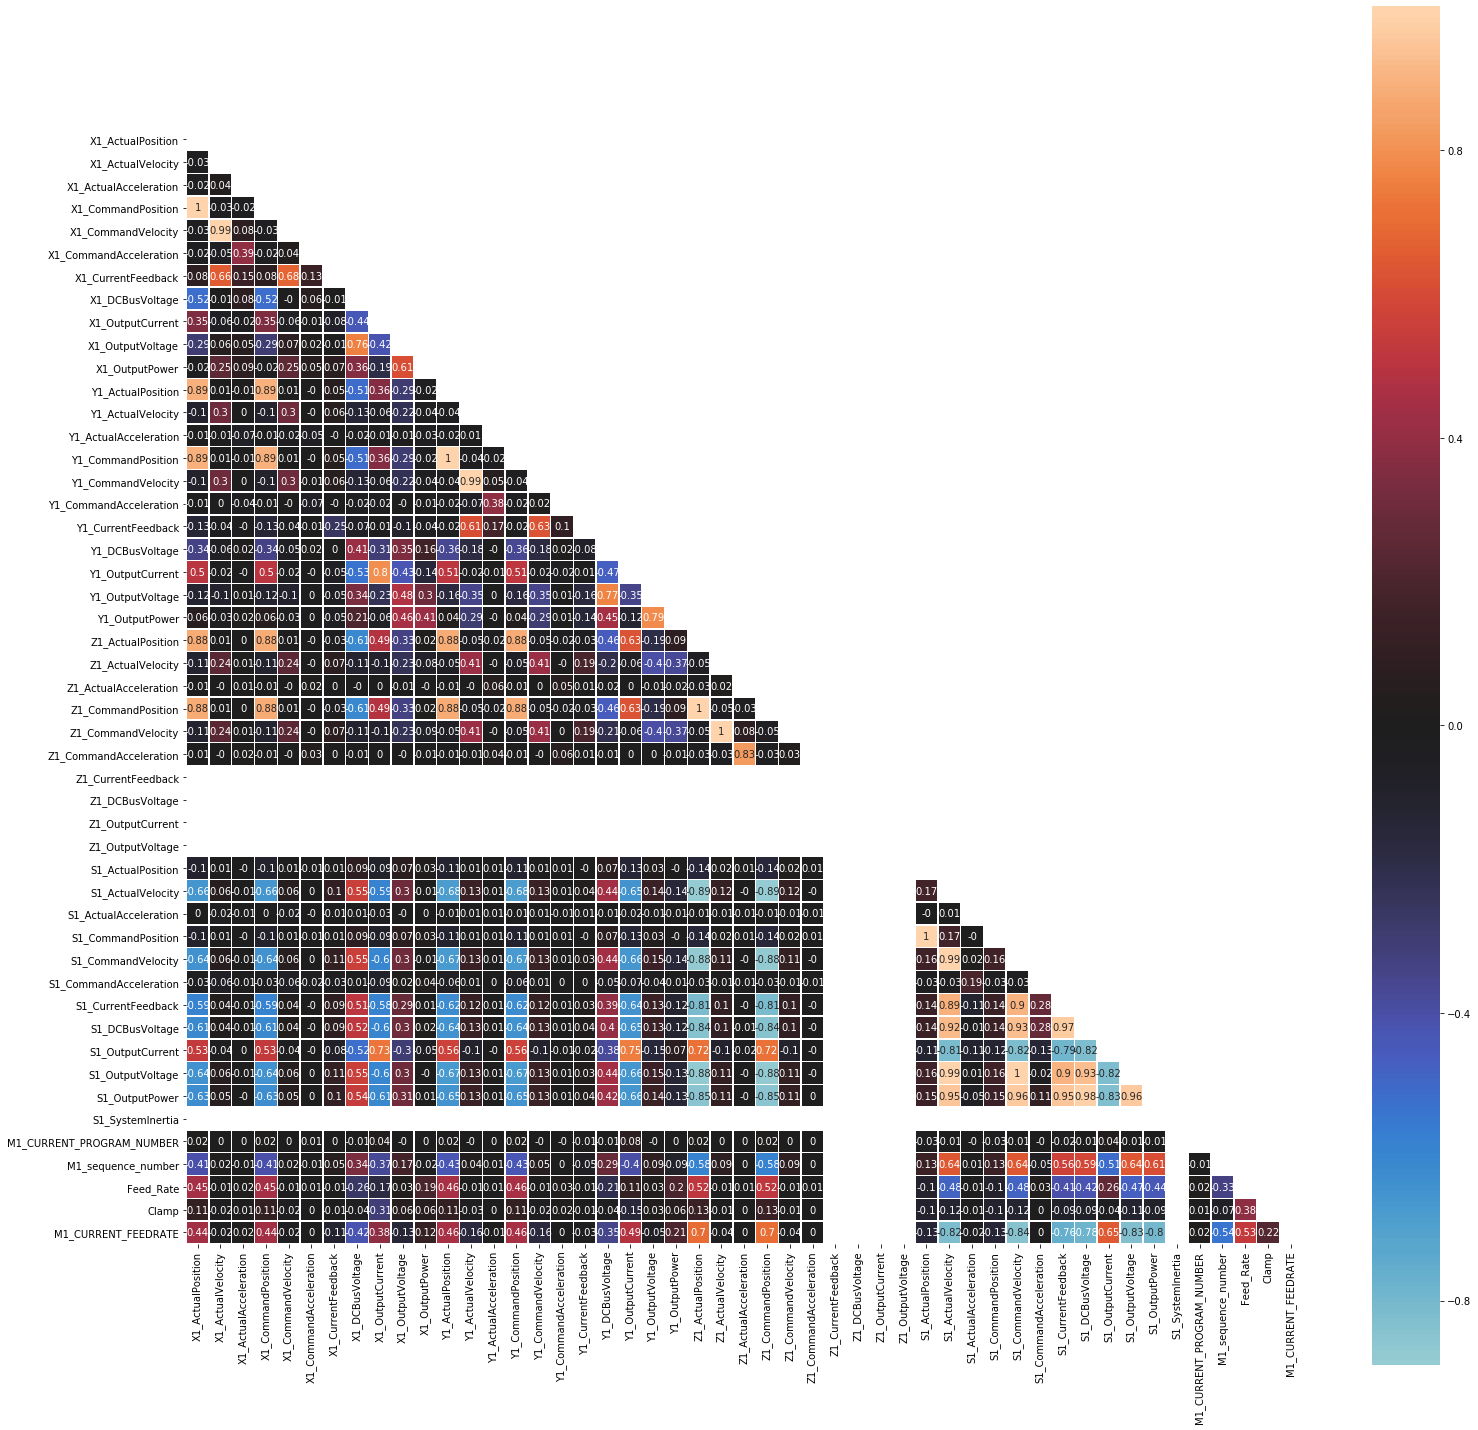

In [4]:
#Phase (2): Data Preprocessing 
#Objective: To prapare the data for model muilding phase

#checking the discriptive statistics of the dataset
Combined_Dataset.describe()

#Features with zero StDev extraction
ZeroStdev=Combined_Dataset.describe().T['std'].loc[Combined_Dataset.describe().T['std']==0]
print('the zero stdev features are:\n\n',ZeroStdev,'\n')

#Checking the correlation between features
mask = np.zeros_like(Combined_Dataset.corr().round(2), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(25,25))
sns.heatmap(Combined_Dataset.corr().round(2), mask=mask,vmax=1,
            center=0,square=True, linewidths=.5,annot=True)

#Highly correlated features extraction
corr_matrix = Combined_Dataset.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                      k=1).astype(np.bool))
Highly_Corr = [column for column in upper.columns if any(upper[column] > 0.95)]
print('The highly Correlated features are:\n\n',Highly_Corr)

#Elimination of the attributes with constant values
Combined_Dataset.drop(['Z1_CurrentFeedback','Z1_DCBusVoltage','Z1_OutputCurrent',
                              'Z1_OutputVoltage','S1_SystemInertia']+Highly_Corr,axis=1,
                       inplace=True)

In [5]:
#Check for Null - NaN Values
if Combined_Dataset.isnull().sum().sum() == 0:
  print("there is no null Values")
if Combined_Dataset.isna().sum().sum() == 0:
    print("there is no NaN Values")

there is no null Values
there is no NaN Values


In [6]:
#Check for erroneous values
print('The number of instances with X1_ActualPosition==198 is :')
print(len(Combined_Dataset.loc[Combined_Dataset.X1_ActualPosition==198]))
print('The number of instances with M1_CURRENT_FEEDRATE ==50 is :')
print(len(Combined_Dataset.loc[Combined_Dataset.M1_CURRENT_FEEDRATE ==50]))
print('The number of instances with X1_ActualPosition==198 and M1_CURRENT_FEEDRATE ==50 is :')
print(len(Combined_Dataset[(Combined_Dataset.X1_ActualPosition==198) &
                     (Combined_Dataset.M1_CURRENT_FEEDRATE ==50)]))
print('the possible values of M1_CURRENT_FEEDRATE is:')
print(list(Combined_Dataset['M1_CURRENT_FEEDRATE'].unique()))
#Erroneous values replacement
Combined_Dataset['X1_ActualPosition'] = Combined_Dataset['X1_ActualPosition'].mask(Combined_Dataset['X1_ActualPosition']>196,196)
Combined_Dataset['M1_CURRENT_FEEDRATE'] = Combined_Dataset['M1_CURRENT_FEEDRATE'].mask(Combined_Dataset['M1_CURRENT_FEEDRATE']==50,20)
Combined_Dataset.head()

The number of instances with X1_ActualPosition==198 is :
4360
The number of instances with M1_CURRENT_FEEDRATE ==50 is :
6253
The number of instances with X1_ActualPosition==198 and M1_CURRENT_FEEDRATE ==50 is :
3182
the possible values of M1_CURRENT_FEEDRATE is:
[50.0, 6.0, 20.0, 15.0, 12.0, 3.0]


,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualPosition,Y1_ActualVelocity,Y1_ActualAcceleration,Y1_CommandAcceleration,Y1_CurrentFeedback,Y1_DCBusVoltage,Y1_OutputCurrent,Y1_OutputVoltage,Y1_OutputPower,Z1_ActualPosition,Z1_ActualVelocity,Z1_ActualAcceleration,Z1_CommandAcceleration,S1_ActualPosition,S1_ActualVelocity,S1_ActualAcceleration,S1_CommandAcceleration,S1_CurrentFeedback,S1_OutputCurrent,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,Feed_Rate,Clamp,M1_CURRENT_FEEDRATE,Machining_Process,Class
0,196.0,0.0,0.00,0.0,0.18,0.02,329.0,2.77,0.00,158.0,-0.03,-6.25,0.0,0.54,0.02,328.0,1.84,0.00,119.0,0.0,0.00,0.0,-361.0,0.0,0.25,0.0,0.52,329.0,1.0,0.0,6,4.0,20.0,Starting,unworn
1,196.0,-10.8,-350.00,-358.0,-10.90,0.19,328.0,23.30,0.00,158.0,-19.80,-750.00,-647.0,-14.50,0.28,325.0,37.80,0.01,119.0,-20.3,-712.00,-674.0,-361.0,0.0,0.25,0.0,-0.29,328.0,1.0,4.0,6,4.0,20.0,Prep,unworn
2,196.0,-17.8,-6.25,0.0,-8.59,0.14,328.0,30.60,0.01,154.0,-32.50,0.00,0.0,-7.79,0.14,327.0,49.40,0.01,115.0,-33.7,37.50,0.0,-361.0,0.0,-0.44,0.0,0.52,328.0,1.0,7.0,6,4.0,20.0,Prep,unworn
3,194.0,-18.0,0.00,0.0,-6.11,0.13,327.0,30.30,0.00,151.0,-32.60,-62.50,0.0,-8.13,0.16,325.0,47.60,0.01,112.0,-33.7,-6.25,0.0,-361.0,0.0,-0.25,0.0,-0.18,328.0,1.0,7.0,6,4.0,20.0,Prep,unworn
4,193.0,-17.9,-18.80,0.0,-5.70,0.11,328.0,30.50,0.00,148.0,-32.00,138.00,0.0,-13.80,0.20,326.0,47.10,0.01,109.0,-33.6,18.80,0.0,-361.0,0.0,-0.19,0.0,0.23,328.0,1.0,7.0,6,4.0,20.0,Prep,unworn


In [7]:
#Dataset Scaling
#Check for attributes Range
print(Combined_Dataset.describe().T[['min','max']].round().head(35))
list(Combined_Dataset.describe().T[['max']].values-Combined_Dataset.describe().T[['min']].values)

# Scaling 
Scaler=MinMaxScaler()
Numirical_Var=Combined_Dataset.drop(['Machining_Process','Class'],axis=1)
Categorical_Var=Combined_Dataset[['Machining_Process','Class']]
header={0:'X1_ActualPosition',1:'X1_ActualVelocity',2:'X1_ActualAcceleration',3:'X1_CommandAcceleration',
        4:'X1_CurrentFeedback',5:'X1_DCBusVoltage',6:'X1_OutputCurrent',7:'X1_OutputVoltage',8:'X1_OutputPower',
        9:'Y1_ActualPosition',10:'Y1_ActualVelocity',11:'Y1_ActualAcceleration',12:'Y1_CommandAcceleration',13:'Y1_CurrentFeedback',
        14:'Y1_DCBusVoltage',15:'Y1_OutputCurrent',16:'Y1_OutputVoltage ',17:'Y1_OutputPower ',18:'Z1_ActualPosition',19:'Z1_ActualVelocity',
        20:'Z1_ActualAcceleration',21:'Z1_CommandAcceleration',22:'S1_ActualPosition',23:'S1_ActualVelocity',24:'S1_ActualAcceleration',
        25:'S1_CommandAcceleration',26:'S1_CurrentFeedback',27:'S1_OutputCurrent',28:'M1_CURRENT_PROGRAM_NUMBER',29:'M1_sequence_number',
        30:'Feed_Rate',31:'Clamp',32:'M1_CURRENT_FEEDRATE',33:'Machining_Process',34:'Class'}

Scaled=pd.DataFrame(Scaler.fit_transform(Numirical_Var))
Scaled_Dataset=pd.concat([Scaled,Categorical_Var],ignore_index=True,axis=1,names=header)
Scaled_Dataset.rename(columns=header, inplace=True)
Scaled_Dataset.head()

                              min     max
X1_ActualPosition           141.0   196.0
X1_ActualVelocity           -20.0    51.0
X1_ActualAcceleration     -1280.0  1440.0
X1_CommandAcceleration    -1000.0  1000.0
X1_CurrentFeedback          -23.0    27.0
X1_DCBusVoltage               0.0     0.0
X1_OutputCurrent            320.0   331.0
X1_OutputVoltage              0.0    75.0
X1_OutputPower               -0.0     0.0
Y1_ActualPosition            72.0   158.0
Y1_ActualVelocity           -33.0    50.0
Y1_ActualAcceleration     -1260.0  1460.0
Y1_CommandAcceleration    -1000.0  1000.0
Y1_CurrentFeedback          -28.0    31.0
Y1_DCBusVoltage               0.0     0.0
Y1_OutputCurrent            319.0   333.0
Y1_OutputVoltage              0.0    77.0
Y1_OutputPower                0.0     0.0
Z1_ActualPosition            28.0   119.0
Z1_ActualVelocity           -52.0    51.0
Z1_ActualAcceleration     -1260.0  1270.0
Z1_CommandAcceleration    -1000.0  1000.0
S1_ActualPosition         -2150.0 

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualPosition,Y1_ActualVelocity,Y1_ActualAcceleration,Y1_CommandAcceleration,Y1_CurrentFeedback,Y1_DCBusVoltage,Y1_OutputCurrent,Y1_OutputVoltage,Y1_OutputPower,Z1_ActualPosition,Z1_ActualVelocity,Z1_ActualAcceleration,Z1_CommandAcceleration,S1_ActualPosition,S1_ActualVelocity,S1_ActualAcceleration,S1_CommandAcceleration,S1_CurrentFeedback,S1_OutputCurrent,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,Feed_Rate,Clamp,M1_CURRENT_FEEDRATE,Machining_Process,Class
0,1.000000,0.286920,0.470588,0.500,0.466931,0.052632,0.818182,0.036737,0.2,1.000000,0.393870,0.460938,0.5000,0.484444,0.046512,0.642857,0.023958,0.00,1.000000,0.502930,0.498024,0.500,0.416047,0.001299,0.500833,0.0,0.105163,0.928571,0.25,0.000000,0.176471,1.0,1.0,Starting,unworn
1,1.000000,0.135021,0.341912,0.321,0.247525,0.500000,0.727273,0.309019,0.2,1.000000,0.156250,0.187500,0.1765,0.227350,0.651163,0.428571,0.492188,0.25,1.000000,0.304688,0.216601,0.163,0.416047,0.001299,0.500833,0.0,0.095483,0.904762,0.25,0.029630,0.176471,1.0,1.0,Prep,unworn
2,1.000000,0.036568,0.468290,0.500,0.293267,0.368421,0.727273,0.405836,0.4,0.953271,0.003606,0.463235,0.5000,0.342051,0.325581,0.571429,0.643229,0.25,0.956284,0.173828,0.512846,0.500,0.416047,0.001299,0.498533,0.0,0.105163,0.904762,0.25,0.051852,0.176471,1.0,1.0,Prep,unworn
3,0.963636,0.033755,0.470588,0.500,0.342376,0.342105,0.636364,0.401857,0.2,0.918224,0.002404,0.440257,0.5000,0.336239,0.372093,0.428571,0.619792,0.25,0.923497,0.173828,0.495553,0.500,0.416047,0.001299,0.499167,0.0,0.096797,0.904762,0.25,0.051852,0.176471,1.0,1.0,Prep,unworn
4,0.945455,0.035162,0.463676,0.500,0.350495,0.289474,0.727273,0.404509,0.2,0.883178,0.009615,0.513971,0.5000,0.239316,0.465116,0.500000,0.613281,0.25,0.890710,0.174805,0.505455,0.500,0.416047,0.001299,0.499367,0.0,0.101697,0.904762,0.25,0.051852,0.176471,1.0,1.0,Prep,unworn


In [8]:
#Categorial attributes and class Encoding
# Machining process Labels extarction
# lowerCase substitution In end machining process
Scaled_Dataset['Machining_Process'].replace(to_replace='end', value='End',inplace=True)
print(Scaled_Dataset['Machining_Process'].unique())

#Class label encoding
Labels={"Class":{'worn':0,
                 'unworn':1}}
Scaled_Dataset.replace(Labels,inplace=True)

# Machining Crocess binary encoding for Each value
Scaled_Dataset = pd.get_dummies(Scaled_Dataset,columns=['Machining_Process'],)
Scaled_Dataset = Scaled_Dataset.reindex(['X1_ActualPosition','X1_ActualVelocity','X1_ActualAcceleration','X1_CommandAcceleration',
        'X1_CurrentFeedback','X1_DCBusVoltage','X1_OutputCurrent','X1_OutputVoltage','X1_OutputPower','Y1_ActualPosition',
        'Y1_ActualVelocity','Y1_ActualAcceleration','Y1_CommandAcceleration','Y1_CurrentFeedback','Y1_DCBusVoltage',
        'Y1_OutputCurrent','Y1_OutputVoltage ','Y1_OutputPower ','Z1_ActualPosition','Z1_ActualVelocity',
        'Z1_ActualAcceleration','Z1_CommandAcceleration','S1_ActualPosition','S1_ActualVelocity',
        'S1_ActualAcceleration','S1_CommandAcceleration','S1_CurrentFeedback','S1_OutputCurrent',
        'M1_CURRENT_PROGRAM_NUMBER','M1_sequence_number','Feed_Rate','Clamp','M1_CURRENT_FEEDRATE',
        'Machining_Process_Starting','Machining_Process_Prep','Machining_Process_Layer 1 Up',
        'Machining_Process_Layer 1 Down','Machining_Process_Repositioning','Machining_Process_Layer 2 Up',
        'Machining_Process_Layer 2 Down','Machining_Process_Layer 3 Up','Machining_Process_Layer 3 Down',
        'Machining_Process_End','Class'], axis=1)
Scaled_Dataset

['Starting' 'Prep' 'Layer 1 Up' 'Layer 1 Down' 'Repositioning'
 'Layer 2 Up' 'Layer 2 Down' 'Layer 3 Up' 'Layer 3 Down' 'End']


,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualPosition,Y1_ActualVelocity,Y1_ActualAcceleration,Y1_CommandAcceleration,Y1_CurrentFeedback,Y1_DCBusVoltage,Y1_OutputCurrent,Y1_OutputVoltage,Y1_OutputPower,Z1_ActualPosition,Z1_ActualVelocity,Z1_ActualAcceleration,Z1_CommandAcceleration,S1_ActualPosition,S1_ActualVelocity,S1_ActualAcceleration,S1_CommandAcceleration,S1_CurrentFeedback,S1_OutputCurrent,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,Feed_Rate,Clamp,M1_CURRENT_FEEDRATE,Machining_Process_Starting,Machining_Process_Prep,Machining_Process_Layer 1 Up,Machining_Process_Layer 1 Down,Machining_Process_Repositioning,Machining_Process_Layer 2 Up,Machining_Process_Layer 2 Down,Machining_Process_Layer 3 Up,Machining_Process_Layer 3 Down,Machining_Process_End,Class
0,1.000000,0.286920,0.470588,0.500000,0.466931,0.052632,0.818182,0.036737,0.2,1.000000,0.393870,0.460938,0.500000,0.484444,0.046512,0.642857,0.023958,0.00,1.000000,0.502930,0.498024,0.500,0.416047,0.001299,0.500833,0.0,0.105163,0.928571,0.25,0.000000,0.176471,1.0,1.0,1,0,0,0,0,0,0,0,0,0,1
1,1.000000,0.135021,0.341912,0.321000,0.247525,0.500000,0.727273,0.309019,0.2,1.000000,0.156250,0.187500,0.176500,0.227350,0.651163,0.428571,0.492188,0.25,1.000000,0.304688,0.216601,0.163,0.416047,0.001299,0.500833,0.0,0.095483,0.904762,0.25,0.029630,0.176471,1.0,1.0,0,1,0,0,0,0,0,0,0,0,1
2,1.000000,0.036568,0.468290,0.500000,0.293267,0.368421,0.727273,0.405836,0.4,0.953271,0.003606,0.463235,0.500000,0.342051,0.325581,0.571429,0.643229,0.25,0.956284,0.173828,0.512846,0.500,0.416047,0.001299,0.498533,0.0,0.105163,0.904762,0.25,0.051852,0.176471,1.0,1.0,0,1,0,0,0,0,0,0,0,0,1
3,0.963636,0.033755,0.470588,0.500000,0.342376,0.342105,0.636364,0.401857,0.2,0.918224,0.002404,0.440257,0.500000,0.336239,0.372093,0.428571,0.619792,0.25,0.923497,0.173828,0.495553,0.500,0.416047,0.001299,0.499167,0.0,0.096797,0.904762,0.25,0.051852,0.176471,1.0,1.0,0,1,0,0,0,0,0,0,0,0,1
4,0.945455,0.035162,0.463676,0.500000,0.350495,0.289474,0.727273,0.404509,0.2,0.883178,0.009615,0.513971,0.500000,0.239316,0.465116,0.500000,0.613281,0.25,0.890710,0.174805,0.505455,0.500,0.416047,0.001299,0.499367,0.0,0.101697,0.904762,0.25,0.051852,0.176471,1.0,1.0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25281,0.054545,0.254571,0.507353,0.500490,0.363366,0.184211,0.636364,0.126790,0.2,0.015187,0.411659,0.454044,0.500810,0.555214,0.139535,0.500000,0.097526,0.00,0.013115,0.502930,0.495553,0.500,0.483163,0.990718,0.288000,0.0,0.337954,0.785714,0.25,0.422222,0.000000,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0
25282,0.054545,0.252180,0.479779,0.500540,0.352079,0.263158,0.636364,0.136605,0.2,0.016355,0.414663,0.458640,0.500775,0.566838,0.186047,0.500000,0.106380,0.00,0.013115,0.502930,0.495553,0.500,0.484395,0.992575,0.637333,0.0,0.323614,0.714286,0.25,0.422222,0.000000,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0
25283,0.036364,0.255977,0.500441,0.500585,0.375842,0.131579,0.636364,0.103316,0.2,0.018692,0.415505,0.458640,0.500740,0.604615,0.255814,0.500000,0.099870,0.00,0.013115,0.502930,0.498024,0.500,0.485651,0.990718,0.425667,0.0,0.390535,0.761905,0.25,0.422222,0.000000,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0
25284,0.036364,0.258087,0.495846,0.500630,0.347921,0.210526,0.636364,0.110345,0.2,0.021028,0.418029,0.463235,0.500705,0.604103,0.302326,0.500000,0.138021,0.00,0.013115,0.502637,0.495553,0.500,0.486884,0.988862,0.285333,0.0,0.357075,0.761905,0.25,0.422222,0.000000,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0


In [9]:
#Phase (3): Model Buliding
#Objective: To fit the data into the selected models

#Splitting The date
y=np.array(Scaled_Dataset['Class'])
x=Scaled_Dataset.drop("Class", axis=1).values
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.8, random_state=241)

# Decesion tree Classifier fitting
DT_Model=DecisionTreeClassifier(criterion="entropy",splitter='best',min_samples_split=2,random_state=241)
DT_Model.fit(x_train,y_train)
DT_Predict=DT_Model.predict(x_test)
print("Decision tree model has been correctly fitted.'\n")

# Support vector Machine fitting
SVM_Model=SVC(kernel="rbf", gamma=0.1, C=2000,random_state=241)
SVM_Model.fit(x_train,y_train)
SVM_Predict=SVM_Model.predict(x_test)
print("Support vector machine model has been correctly fitted.'\n")

# Multi layer perceptron fitting
MLP_Model=MLPClassifier((100,100,100),activation='relu',solver='adam',max_iter=1000,random_state=241)
MLP_Model.fit(x_train,y_train)
MLP_Predict=MLP_Model.predict(x_test)
print("Multi-layer perceptron model has been correctly fitted.'\n")

KNN_Model=KNeighborsClassifier(n_neighbors=9,weights="uniform",p=2)
KNN_Model.fit(x_train,y_train)
KNN_Predict=KNN_Model.predict(x_test)
print("K-nearest neighbor model has been correctly fitted.'\n")

# Logistic Regression  fitting
LR_Model=LogisticRegression(random_state=241,C=1000)
LR_Model.fit(x_train,y_train)
LR_Predict=LR_Model.predict(x_test)
print("Logistic regression model has been correctly fitted.'\n")

# Mixed Naive Bayes fitting
MNB_Model=MixedNB(categorical_features=[33,34,35,36,37,38,39,40,41,42])
MNB_Model.fit(x_train,y_train)
MNB_Predict=MNB_Model.predict(x_test)
print("Mixed naive bayes model has been correctly fitted.'\n")

Decision tree model has been correctly fitted.'

Support vector machine model has been correctly fitted.'

Multi-layer perceptron model has been correctly fitted.'

K-nearest neighbor model has been correctly fitted.'

Logistic regression model has been correctly fitted.'

Mixed naive bayes model has been correctly fitted.'



Decision tree classifier mitrics:

Accuracy score: 99.2
Sensitivity score: 99.2
Specificity Score: 99.2 



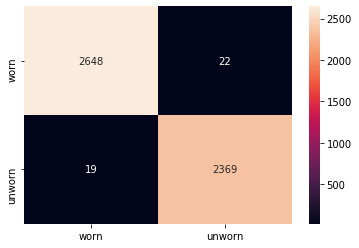

--------------------------------------------------------------------
Support vector machine classifier mitrics:

Accuracy score: 87.6
Sensitivity score: 87.5
Specificity Score: 87.6 



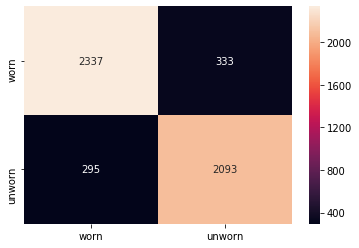

--------------------------------------------------------------------
Multi-layer perceptron classifier mitrics:

Accuracy score: 94.2
Sensitivity score: 95.3
Specificity Score: 93.0 



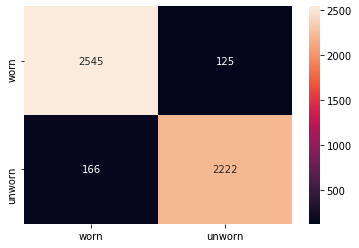

--------------------------------------------------------------------
K-nearest neighbor classifier mitrics:

Accuracy score: 90.6
Sensitivity score: 90.9
Specificity Score: 90.3 



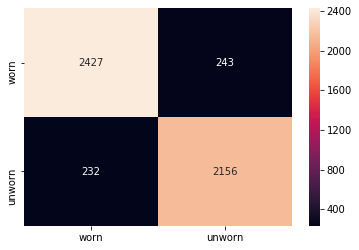

--------------------------------------------------------------------
Logistic regression classifier mitrics:

Accuracy score: 60.1
Sensitivity score: 62.8
Specificity Score: 57.0 



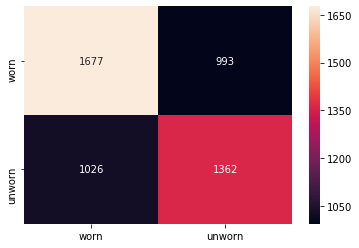

--------------------------------------------------------------------
Mixed naive bayes classifier mitrics:

Accuracy score: 57.1
Sensitivity score: 100.0
Specificity Score: 9.2 



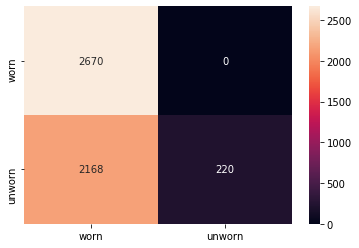

In [10]:
#Phase(4): Results presentation
#Objective: To present the evaluation metrics 

#Decesion tree evaluation mitrics
print('Decision tree classifier mitrics:\n')
DT_Acc = round(accuracy_score(y_test, DT_Predict)*100,1)
DT_Conf = confusion_matrix(y_test, DT_Predict)
DT_Sen = round((DT_Conf[0,0]/(DT_Conf[0,0]+DT_Conf[0,1]))*100,1)
DT_Spec = round((DT_Conf[1,1]/(DT_Conf[1,0]+DT_Conf[1,1]))*100,1)
print("Accuracy score:",DT_Acc)
print("Sensitivity score:",DT_Sen)
print("Specificity Score:",DT_Spec,'\n')
sns.heatmap(DT_Conf,annot=True,fmt="0000.0f",
            xticklabels=["worn","unworn"],yticklabels=['worn','unworn'])
plt.show()
print("--------------------------------------------------------------------")

#Support vector machine evaluation mitrics
print('Support vector machine classifier mitrics:\n')
SVM_Acc = round(accuracy_score(y_test, SVM_Predict)*100,1)
SVM_Conf=confusion_matrix(y_test, SVM_Predict)
SVM_Sen = round((SVM_Conf[0,0]/(SVM_Conf[0,0]+SVM_Conf[0,1]))*100,1)
SVM_Spec = round((SVM_Conf[1,1]/(SVM_Conf[1,0]+SVM_Conf[1,1]))*100,1)
print("Accuracy score:",SVM_Acc)
print("Sensitivity score:",SVM_Sen)
print("Specificity Score:",SVM_Spec,'\n')
sns.heatmap(SVM_Conf,annot=True,fmt="0000.0f",
            xticklabels=["worn","unworn"],yticklabels=['worn','unworn'])
plt.show()
print("--------------------------------------------------------------------")

#Multi-layer perceptron evaluation mitrics
print('Multi-layer perceptron classifier mitrics:\n')
MLP_Acc = round(accuracy_score(y_test, MLP_Predict)*100,1)
MLP_Conf = confusion_matrix(y_test, MLP_Predict)
MLP_Sen = round((MLP_Conf[0,0]/(MLP_Conf[0,0]+MLP_Conf[0,1]))*100,1)
MLP_Spec = round((MLP_Conf[1,1]/(MLP_Conf[1,0]+MLP_Conf[1,1]))*100,1)
print("Accuracy score:",MLP_Acc)
print("Sensitivity score:",MLP_Sen)
print("Specificity Score:",MLP_Spec,'\n')
sns.heatmap(MLP_Conf,annot=True,fmt="0000.0f",
            xticklabels=["worn","unworn"],yticklabels=['worn','unworn'])
plt.show()
print("--------------------------------------------------------------------")

#K-nearest neighbor evaluation mitrics
print('K-nearest neighbor classifier mitrics:\n')
KNN_Acc = round(accuracy_score(y_test, KNN_Predict)*100,1)
KNN_Conf=confusion_matrix(y_test, KNN_Predict)
KNN_Sen = round((KNN_Conf[0,0]/(KNN_Conf[0,0]+KNN_Conf[0,1]))*100,1)
KNN_Spec = round((KNN_Conf[1,1]/(KNN_Conf[1,0]+KNN_Conf[1,1]))*100,1)
print("Accuracy score:",KNN_Acc)
print("Sensitivity score:",KNN_Sen)
print("Specificity Score:",KNN_Spec,'\n')
sns.heatmap(KNN_Conf,annot=True,fmt="0000.0f",
            xticklabels=["worn","unworn"],yticklabels=['worn','unworn'])
plt.show()
print("--------------------------------------------------------------------")

#Logistic Regression evaluation mitrics
print('Logistic regression classifier mitrics:\n')
LR_Acc = round(accuracy_score(y_test, LR_Predict)*100,1)
LR_Conf = confusion_matrix(y_test, LR_Predict)
LR_Sen = round((LR_Conf[0,0]/(LR_Conf[0,0]+LR_Conf[0,1]))*100,1)
LR_Spec = round((LR_Conf[1,1]/(LR_Conf[1,0]+LR_Conf[1,1]))*100,1)
print("Accuracy score:",LR_Acc)
print("Sensitivity score:",LR_Sen)
print("Specificity Score:",LR_Spec,'\n')
sns.heatmap(LR_Conf,annot=True,fmt="0000.0f",
            xticklabels=["worn","unworn"],yticklabels=['worn','unworn'])
plt.show()
print("--------------------------------------------------------------------")

#Mixed naive bayes evaluation mitrics
print('Mixed naive bayes classifier mitrics:\n')
MNB_Acc = round(accuracy_score(y_test, MNB_Predict)*100,1)
MNB_Conf=confusion_matrix(y_test, MNB_Predict)
MNB_Sen = round((MNB_Conf[0,0]/(MNB_Conf[0,0]+MNB_Conf[0,1]))*100,1)
MNB_Spec = round((MNB_Conf[1,1]/(MNB_Conf[1,0]+MNB_Conf[1,1]))*100,1)
print("Accuracy score:",MNB_Acc)
print("Sensitivity score:",MNB_Sen)
print("Specificity Score:",MNB_Spec,'\n')
sns.heatmap(MNB_Conf,annot=True,fmt="0000.0f",
            xticklabels=["worn","unworn"],yticklabels=['worn','unworn'])
plt.show()



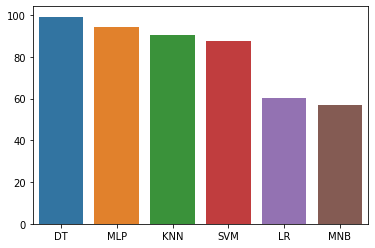

In [11]:
# overall accuracy scores plotting
Accuracy=[DT_Acc,MLP_Acc,KNN_Acc,SVM_Acc,LR_Acc,MNB_Acc]
Models=['DT','MLP','KNN','SVM','LR','MNB']
sns.barplot(Models,Accuracy)

In [12]:
# Features importance
features = [(Scaled_Dataset.columns[i], v) for i,v in enumerate(DT_Model.feature_importances_)]
features.sort(key=lambda x: x[1], reverse = True)
for item in features[:]:
    print("{0}: {1:0.4f}".format(item[0], item[1]))

Z1_ActualPosition: 0.7182
S1_ActualPosition: 0.0730
Y1_OutputCurrent: 0.0347
M1_CURRENT_FEEDRATE: 0.0257
M1_CURRENT_PROGRAM_NUMBER: 0.0178
X1_ActualPosition: 0.0170
Feed_Rate: 0.0140
Clamp: 0.0133
X1_DCBusVoltage: 0.0128
Y1_ActualPosition: 0.0117
Z1_ActualVelocity: 0.0105
S1_CurrentFeedback: 0.0104
S1_OutputCurrent: 0.0094
X1_ActualAcceleration: 0.0059
X1_CurrentFeedback: 0.0033
X1_OutputCurrent: 0.0029
Machining_Process_Prep: 0.0029
X1_OutputVoltage: 0.0023
M1_sequence_number: 0.0021
Y1_OutputVoltage : 0.0014
Machining_Process_Layer 2 Down: 0.0011
Machining_Process_Layer 3 Down: 0.0011
Machining_Process_Layer 3 Up: 0.0011
X1_ActualVelocity: 0.0009
Y1_CurrentFeedback: 0.0009
Machining_Process_Layer 2 Up: 0.0008
S1_ActualAcceleration: 0.0008
Y1_ActualAcceleration: 0.0006
Machining_Process_Starting: 0.0005
Y1_ActualVelocity: 0.0004
Z1_CommandAcceleration: 0.0004
Machining_Process_Layer 1 Down: 0.0004
Z1_ActualAcceleration: 0.0004
Machining_Process_Layer 1 Up: 0.0004
Machining_Process_End

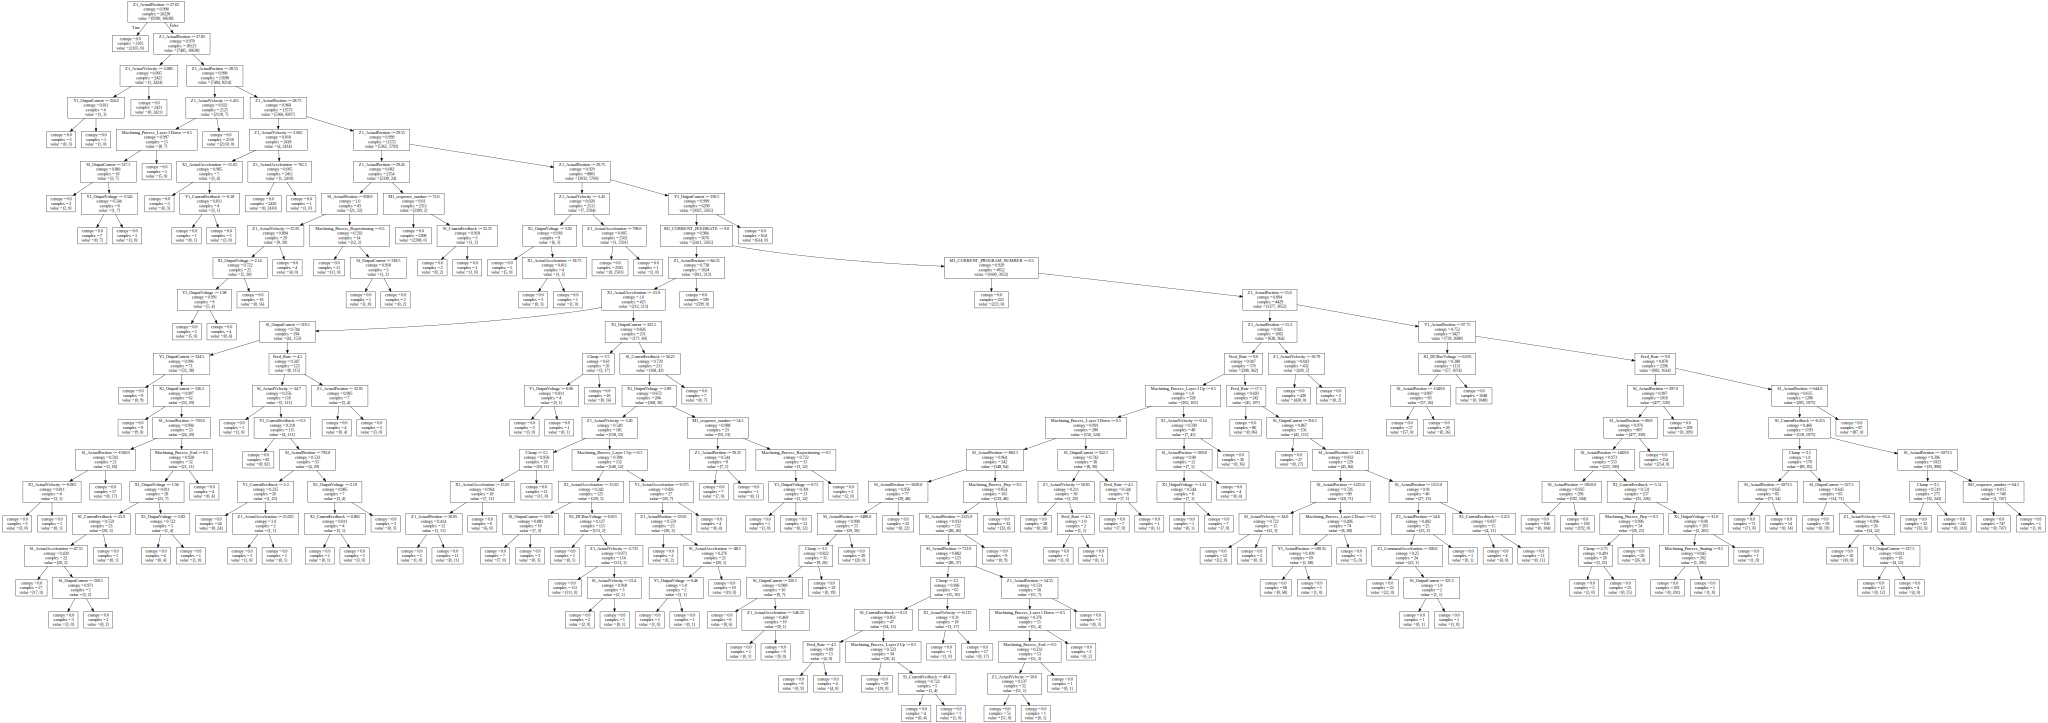

In [13]:
# Decesion tree plotting
Combined_Dataset= pd.get_dummies(Combined_Dataset,columns=['Machining_Process'],)
Y=np.array(Combined_Dataset['Class'])
X=Combined_Dataset.drop("Class", axis=1).values
x_train, x_test, y_train, y_test = train_test_split(X,Y, train_size=0.8, random_state=241)

DT_Mod=DecisionTreeClassifier(criterion="entropy",splitter='best',
                              min_samples_split=2,random_state=241)
DT_Mod.fit(x_train,y_train)
DT_Pred=DT_Mod.predict(x_test)

dot_data = export_graphviz(DT_Mod, out_file=None,
                           feature_names = (Combined_Dataset.drop('Class', axis = 1)).columns)
graph = graphviz.Source(dot_data) 
graph

In [14]:
#Decesion rules extraction
tree_rules = export_text(DT_Mod, feature_names=['X1_ActualPosition','X1_ActualVelocity','X1_ActualAcceleration','X1_CommandAcceleration',
        'X1_CurrentFeedback','X1_DCBusVoltage','X1_OutputCurrent','X1_OutputVoltage','X1_OutputPower','Y1_ActualPosition',
        'Y1_ActualVelocity','Y1_ActualAcceleration','Y1_CommandAcceleration','Y1_CurrentFeedback','Y1_DCBusVoltage',
        'Y1_OutputCurrent','Y1_OutputVoltage ','Y1_OutputPower ','Z1_ActualPosition','Z1_ActualVelocity',
        'Z1_ActualAcceleration','Z1_CommandAcceleration','S1_ActualPosition','S1_ActualVelocity',
        'S1_ActualAcceleration','S1_CommandAcceleration','S1_CurrentFeedback','S1_OutputCurrent',
        'M1_CURRENT_PROGRAM_NUMBER','M1_sequence_number','Feed_Rate','Clamp','M1_CURRENT_FEEDRATE',
        'Machining_Process_Starting','Machining_Process_Prep','Machining_Process_Layer 1 Up',
        'Machining_Process_Layer 1 Down','Machining_Process_Repositioning','Machining_Process_Layer 2 Up',
        'Machining_Process_Layer 2 Down','Machining_Process_Layer 3 Up','Machining_Process_Layer 3 Down',
        'Machining_Process_End',"Class"])
print(tree_rules)

|--- Z1_ActualPosition <= 27.65
|   |--- class: unworn
|--- Z1_ActualPosition >  27.65
|   |--- Z1_ActualPosition <= 27.85
|   |   |--- Z1_ActualVelocity <= -5.88
|   |   |   |--- Y1_OutputCurrent <= 324.00
|   |   |   |   |--- class: worn
|   |   |   |--- Y1_OutputCurrent >  324.00
|   |   |   |   |--- class: unworn
|   |   |--- Z1_ActualVelocity >  -5.88
|   |   |   |--- class: worn
|   |--- Z1_ActualPosition >  27.85
|   |   |--- Z1_ActualPosition <= 28.55
|   |   |   |--- Z1_ActualVelocity <= -1.41
|   |   |   |   |--- Machining_Process_Layer 2 Up <= 0.50
|   |   |   |   |   |--- S1_OutputCurrent <= 317.50
|   |   |   |   |   |   |--- class: unworn
|   |   |   |   |   |--- S1_OutputCurrent >  317.50
|   |   |   |   |   |   |--- Y1_OutputVoltage  <= 3.55
|   |   |   |   |   |   |   |--- class: worn
|   |   |   |   |   |   |--- Y1_OutputVoltage  >  3.55
|   |   |   |   |   |   |   |--- class: unworn
|   |   |   |   |--- Machining_Process_Layer 2 Up >  0.50
|   |   |   |   |   |--- cl